<a href="https://colab.research.google.com/github/ManarHelmy/Chest_xray_diagnosis/blob/main/chest_xray_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chest X-ray diagnosis**


Covid - Normal - Pneumonia

---

In [ ]:
!pip install Kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!kaggle datasets download -d alsaniipe/chest-x-ray-image

Dataset URL: https://www.kaggle.com/datasets/alsaniipe/chest-x-ray-image
License(s): apache-2.0
chest-x-ray-image.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/chest-x-ray-image.zip

Archive:  /content/chest-x-ray-image.zip
replace Data/test/COVID19/COVID19(460).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout
from keras.models import Sequential
from keras.layers import Dense,Input,Flatten
from tensorflow.keras.utils import load_img,img_to_array
from sklearn.metrics import confusion_matrix

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory('/content/Data/train',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False)
test_data = train_datagen.flow_from_directory('/content/Data/test',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
np.unique(train_data.labels)

array([0, 1, 2], dtype=int32)

In [ ]:
train_data.image_shape

(224, 224, 3)

In [ ]:
train_data.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [ ]:
vgg16_model = vgg16.VGG16(include_top=False, input_shape=(224,224,3))
vgg16_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in vgg16_model.layers[:]:
  layer.trainable = False
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │          12,291 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 119,558,147 (456.08 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_data.labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [ ]:
train_data[0][0][2][0].shape

(224, 3)

In [ ]:
train_data.samples

5144

In [ ]:
test_data.samples

1288

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# from tensorflow import SparseCategoricalCrossentropy
# model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
batch_size=128
from tensorflow import keras
results = model.fit(train_data, epochs=100, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks=keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
                  )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 116s 634ms/step - accuracy: 0.5503 - loss: 9.5762 - val_accuracy: 0.8564 - val_loss: 0.3866
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 80s 499ms/step - accuracy: 0.8683 - loss: 0.3440 - val_accuracy: 0.9216 - val_loss: 0.2408
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 79s 483ms/step - accuracy: 0.9337 - loss: 0.1992 - val_accuracy: 0.8672 - val_loss: 0.3180
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 84s 521ms/step - accuracy: 0.9260 - loss: 0.2066 - val_accuracy: 0.9581 - val_loss: 0.1224
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 80s 493ms/step - accuracy: 0.9388 - loss: 0.1580 - val_accuracy: 0.9449 - val_loss: 0.1552
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 80s 484ms/step - accuracy: 0.9470 - loss: 0.1628 - val_accuracy: 0.9550 - val_loss: 0.1208
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 78s 485ms/step - accuracy: 0.9682 - loss: 0.0900 - val_accuracy: 0.9472 - val_loss: 0.1482
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 80s 497ms/step - accuracy: 0.9642 

In [ ]:
loss , acc =model.evaluate(test_data)
acc

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.9607 - loss: 0.1150


0.967391312122345

In [ ]:
yp = (model.predict(test_data)>=0.5).astype(int)
yp

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 389ms/step


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [ ]:
yp.shape

(1288, 3)

In [ ]:
yp = np.where(yp == 1)[1]
yp

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
yp.shape

(1288,)

In [ ]:
model.save("chest-xray.h5")

Covid Sample


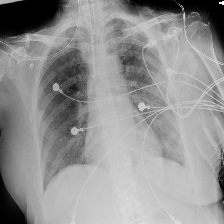

In [ ]:
print("Covid Sample")
img_covid = load_img('/content/Data/train/COVID19/COVID19(101).jpg',target_size=(224,224))
# plt.imshow()
img_covid

Normal Sample


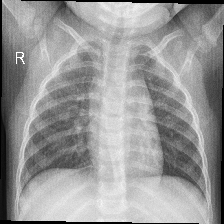

In [ ]:
print('Normal Sample')
# img_normal = load_img('/content/normal-chest-x-ray.jpg',target_size=(224,224))
img_normal = load_img('/content/NORMAL-1063934-0001.jpeg',target_size=(224,224))
# plt.imshow(img_normal)
img_normal

Pneumonia Sample


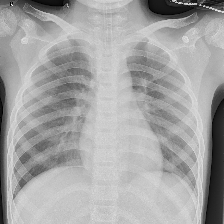

In [ ]:
print('Pneumonia Sample')
img_p = load_img('/content/BACTERIA-1065620-0001.jpeg',target_size=(224,224))
# plt.imshow(img_normal)
img_p

Text(0.5, 1.0, 'Pneumonia')

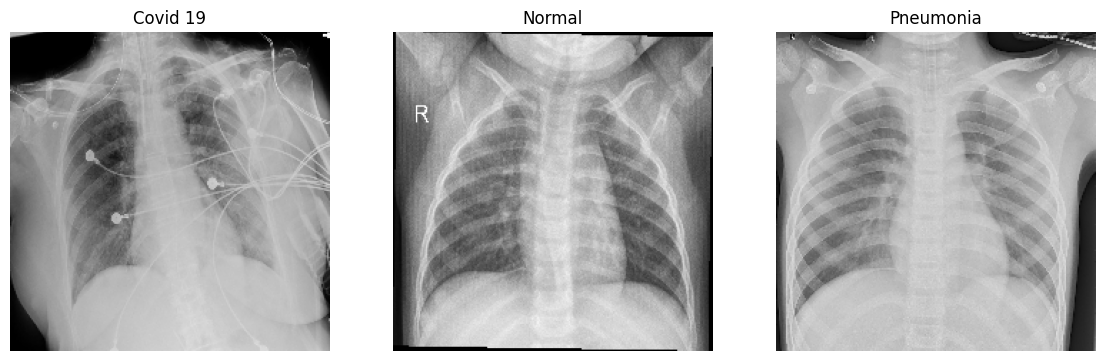

In [ ]:
fig = plt.figure(figsize=(14,7))
# plt.grid=False
fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img_covid)
plt.title('Covid 19')
fig.add_subplot(1, 3, 2)
plt.axis('off')
plt.imshow(img_normal)
plt.title('Normal')
fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.imshow(img_p)
plt.title('Pneumonia')

In [ ]:
img_covid = img_to_array(img_covid)
img_normal = img_to_array(img_normal)
img_p = img_to_array(img_p)
img_covid = img_covid/255
img_normal = img_normal/255
img_p = img_p/255
img_covid = img_covid.reshape(1,224,224,3)
img_normal = img_normal.reshape(1,224,224,3)
img_p = img_p.reshape(1,224,224,3)
img_normal.shape

(1, 224, 224, 3)

In [ ]:
df = pd.DataFrame({'filename':test_data.filenames,'y_actual':test_data.classes,'Y_pred':yp})
df

,filename,y_actual,Y_pred
0,COVID19/COVID19(460).jpg,0,0
1,COVID19/COVID19(461).jpg,0,0
2,COVID19/COVID19(462).jpg,0,0
3,COVID19/COVID19(463).jpg,0,0
4,COVID19/COVID19(464).jpg,0,0
...,...,...,...
1283,PNEUMONIA/PNEUMONIA(4268).jpg,2,2
1284,PNEUMONIA/PNEUMONIA(4269).jpg,2,2
1285,PNEUMONIA/PNEUMONIA(4270).jpg,2,2
1286,PNEUMONIA/PNEUMONIA(4271).jpg,2,2


In [ ]:
p1 = (model.predict(img_covid)>=0.5).astype(int).reshape(3,)
p1 = int(np.where(p1 == 1)[0])

if p1 ==0:
  print("Class 0: Covid")
elif p1==1:
  print("Class 1: Normal")
else:
  print('Class 1: Pneumonia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Class 0: Covid


<ipython-input-43-114b67dd1277>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p1 = int(np.where(p1 == 1)[0])


In [ ]:
p1 = (model.predict(img_normal)>=0.5).astype(int).reshape(3,)
p1 = int(np.where(p1 == 1)[0])

if p1 ==0:
  print("Class 0: Covid")
elif p1==1:
  print("Class 1: Normal")
else:
  print('Class 1: Pneumonia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Class 1: Normal


<ipython-input-44-7c2c3373e292>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p1 = int(np.where(p1 == 1)[0])


In [ ]:
p1 = (model.predict(img_p)>=0.5).astype(int).reshape(3,)
p1 = int(np.where(p1 == 1)[0])

if p1 ==0:
  print("Class 0: Covid")
elif p1==1:
  print("Class 1: Normal")
else:
  print('Class 2: Pneumonia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Class 2: Pneumonia


<ipython-input-45-624d5bfbfb3c>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p1 = int(np.where(p1 == 1)[0])


In [ ]:
test_data.labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [ ]:
m = confusion_matrix(test_data.labels,yp)
m

array([[114,   0,   2],
       [  0, 287,  30],
       [  0,  10, 845]])

Heatmap



<Axes: xlabel='Predicted', ylabel='Actual'>

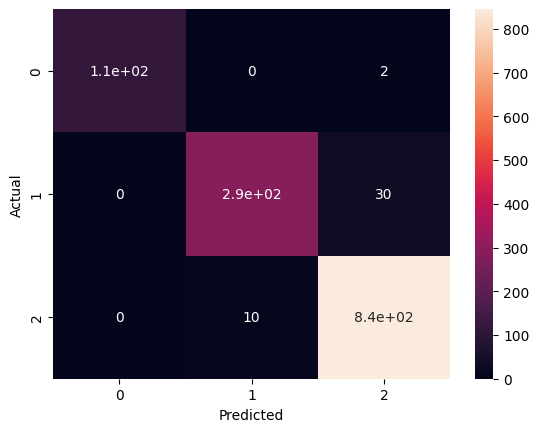

In [ ]:
print("Heatmap\n")
m = pd.crosstab(test_data.labels, yp, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(m,annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_data.labels, yp))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       116
           1       0.97      0.91      0.93       317
           2       0.96      0.99      0.98       855

    accuracy                           0.97      1288
   macro avg       0.98      0.96      0.97      1288
weighted avg       0.97      0.97      0.97      1288



---